
# Train Logisitic Regression
This notebook trains and exports a LR model on the Waseem and Hovy 2016 dataset.

**Trains on:** Waseem and Hovy (2016)

In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from google.colab import drive
import preprocessor as p
import html
import pickle
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
NUM_FOLDS = 10
MAX_N_GRAM = 4
FILENAME = "drive/MyDrive/Colab Notebooks/data/twitter_data.pkl"

In [ ]:
def preprocess(data):
    """Preprocesses the data by cleaning URLs and MENTIONS since these do not
    contain any valuable information."""
    p.set_options(p.OPT.URL, p.OPT.MENTION)

    return list(map(lambda text: p.clean(html.unescape(text)), data))

def convert_waseem_data(data):
    """Converts the Waseem and Hovy dataset by creating binary labels"""
    X = []
    y = []
    for i in range(len(data)):
        X.append(data[i]['text'])
        label = data[i]['label']
        if label in ['racism', 'sexism']:
          label = 1
        else:
          label = 0
        y.append(label)

    return X, y

In [ ]:
# Mount drive for loading the datasets
drive.mount('/content/drive')
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


## Preprocess and split data

In [ ]:
data = pickle.load(open(FILENAME, 'rb'))
X, y = convert_waseem_data(data)
X = preprocess(X)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y, test_size=0.10)

## Tokenize data

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, MAX_N_GRAM), analyzer="char")
X_train_transformed = vectorizer.fit_transform(X_train)

## Fit and export LR model

In [ ]:
model = LogisticRegressionCV(cv=10, random_state=0, max_iter=200)
model.fit(X_train_transformed, y_train)

LogisticRegressionCV(cv=10, max_iter=200, random_state=0)

In [ ]:
dump(model, '/content/drive/MyDrive/Colab Notebooks/output/logistic-regression-waseem.joblib') 

['/content/drive/MyDrive/Colab Notebooks/output/logistic-regression-waseem-n-gram.joblib']

## Test LR model

In [ ]:
X_test_transformed = vectorizer.transform(X_test)
probabilities = model.predict_proba(X_test_transformed)
predictions = np.argmax(probabilities, axis=1)

In [ ]:
print(metrics.accuracy_score(y_test, predictions))

0.853325046612803


LR models are always well-calibrated by default

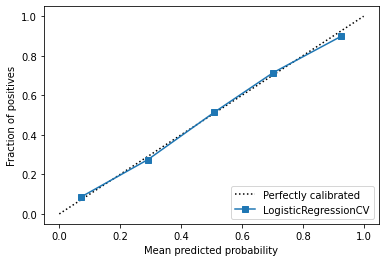

In [ ]:
probs = np.max(probabilities, axis=1)
disp = CalibrationDisplay.from_estimator(model, X_test_transformed, y_test)
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1104
           1       0.81      0.70      0.75       505

    accuracy                           0.85      1609
   macro avg       0.84      0.81      0.82      1609
weighted avg       0.85      0.85      0.85      1609

